# Using SCProcessing Package for Lukassen2020_Lung train test split.
- Making a train split column
- Cleaning metadata
- Adding numeric cluster labels

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import seaborn as sns
from SCProcessing import TrainSplit
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [ ]:
adata = sc.read_h5ad('~/Lukassen2020_Lung/Lukassen2020_Lung_qc_hvg_anno_5k.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 39778 × 5000
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'barcodes', 'ID', 'Sex', 'Age', 'Smoking', 'UMI.count', 'Gene.count', 'Cell.type', 'MT.ratio', 'barcodes1', 'celltypes', 'percent_mt', 'RNA_snn_res.0.2', 'RNA_snn_res.0.4', 'RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'RNA_snn_res.1', 'seurat_clusters', 'kmeans_9', 'cluster'
    var: 'vst.mean', 'vst.variance', 'vst.variance.expected', 'vst.variance.standardized', 'vst.variable'
    uns: 'neighbors'
    obsm: 'X_harmony', 'X_pca', 'X_umap'
    varm: 'HARMONY', 'PCs'
    obsp: 'distances'

There is a lot of extra metadata that is redundant so I will remove.

In [5]:
adata.obs = adata.obs.drop(columns=['RNA_snn_res.0.6', 'RNA_snn_res.0.8', 'barcodes1', 'RNA_snn_res.1', 'seurat_clusters'])

#### Lets quickly visualize what the data looks like

... storing 'orig.ident' as categorical
... storing 'ID' as categorical
... storing 'Sex' as categorical
... storing 'Smoking' as categorical
... storing 'Cell.type' as categorical
... storing 'celltypes' as categorical


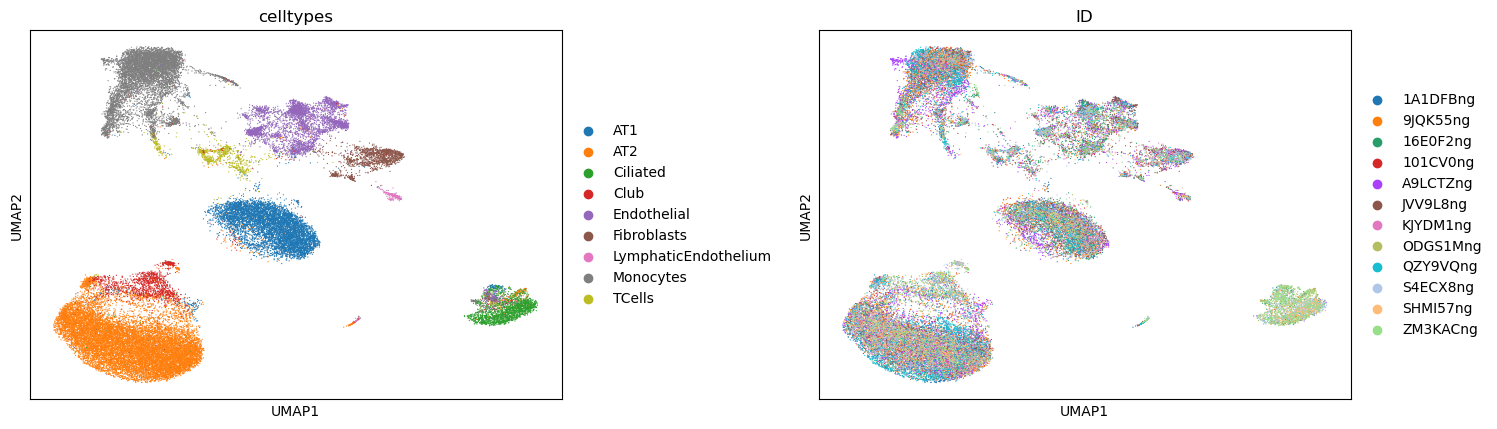

In [7]:
sc.pl.umap(adata, color=['celltypes', 'ID'], wspace=0.35)

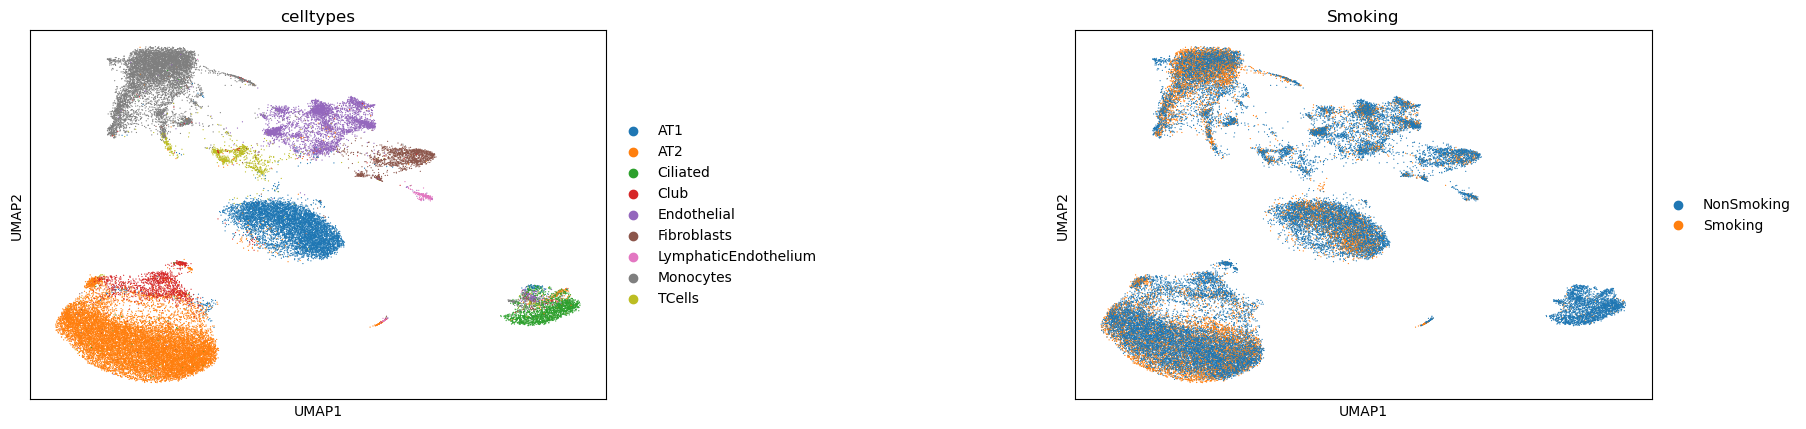

In [8]:
sc.pl.umap(adata, color=['celltypes', 'Smoking'], wspace=0.65)

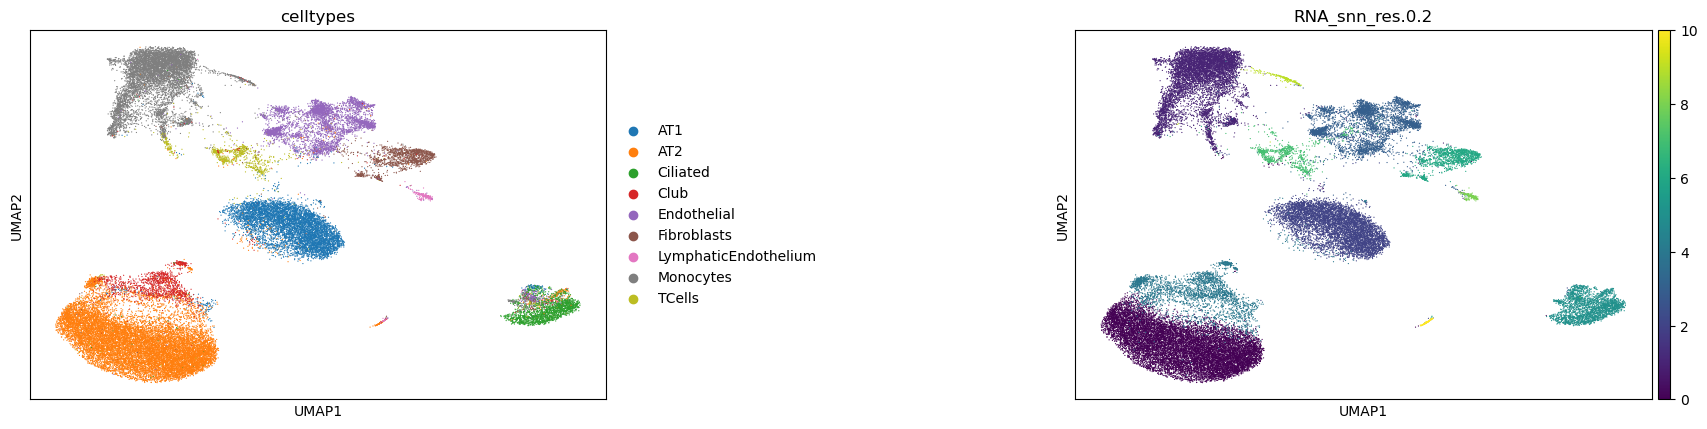

In [9]:
sc.pl.umap(adata, color=['celltypes', 'RNA_snn_res.0.2'], wspace=0.65)

#### Prep for N-ACT

- Create encoded version of 'celltypes' column
- Generate a train/test split of the data (80/20)

In [10]:
encoder_celltype = LabelEncoder()
encoder_celltype.fit(adata.obs['celltypes'])

LabelEncoder()

In [13]:
adata.obs['encoded_celltypes']= encoder_celltype.transform(adata.obs['celltypes']).tolist()

In [14]:
adata.raw.X

<39778x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 18376645 stored elements in Compressed Sparse Row format>

In [13]:
# adata.raw = adata

Create a column labeled 'cluster' for SCProcessing to create a balanced split

In [15]:
adata.obs['cluster'] = adata.obs['encoded_celltypes'].tolist()

In [16]:
adata.obs['cluster'].value_counts()

1    15158
7     7534
0     6759
4     4159
2     1998
5     1554
3     1374
8      968
6      274
Name: cluster, dtype: int64

In [17]:
print(f'80%: {39000 * 0.8}')
print(f'20%: {39000 * 0.2}')

80%: 31200.0
20%: 7800.0


In [22]:
obj = TrainSplit(adata, 31200, 0, 7800, balancedSplit=True)

In [23]:
obj.Split()

==> Splitting:
GOT HERE
==> Saving cluster ratios:
    -> Number of clusters: 9
-><- Saved cluster ratios to object attributes
-><- Splitting done
Splitting took 0.0834188461303711 seconds


In [24]:
obj.clusters_ratios

{1: 0.38106491025189804,
 7: 0.18940117652974006,
 0: 0.16991804515058576,
 4: 0.10455528181406808,
 5: 0.03906682085574941,
 3: 0.03454170647091357,
 6: 0.006888229674694555,
 2: 0.05022876967167781,
 8: 0.024335059580672735}

In [25]:
adata.obs['split'].value_counts()

train    31978
test      7800
valid        0
Name: split, dtype: int64

In [26]:
adata[adata.obs['split'] == 'test'].obs['cluster'].value_counts()

1    2998
7    1471
0    1303
4     807
2     390
5     316
3     271
8     190
6      54
Name: cluster, dtype: int64

In [28]:
from scipy.sparse import csr_matrix
adata.X = csr_matrix(adata.X, dtype=np.float32)

In [29]:
raw_mat = adata.raw.X

In [30]:
raw_mat = raw_mat.todense()

In [31]:
raw_mat = np.array(raw_mat, dtype=np.float32)

In [32]:
raw_mat

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [ 1.,  0., 32., ...,  0.,  0.,  0.],
       [ 0.,  0.,  4., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.]], dtype=float32)

In [33]:
import anndata
adata2 = anndata.AnnData(raw_mat)
adata2.X = csr_matrix(adata2.X, dtype=np.float32)

In [34]:
adata.raw = adata2

In [35]:
adata.raw.X.todense()

matrix([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 1.,  0., 32., ...,  0.,  0.,  0.],
        [ 0.,  0.,  4., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.]], dtype=float32)

In [36]:
adata.write_h5ad('~/Lukassen2020_Lung/Lukassen2020_Lung_qc_hvg_anno_5k_split.h5ad')